### Final Project

In [28]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report
from ISLP import load_data
from sklearn.cluster import \
     (KMeans,
      AgglomerativeClustering)
from scipy.cluster.hierarchy import \
     (dendrogram,
      cut_tree)
from ISLP.cluster import compute_linkage

np.random.seed(2)
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, DecisionTreeRegressor
from xgboost import XGBClassifier
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import GridSearchCV

### 1.1 Import Datasets

In [29]:
# Load the New dataset
new_safe_urls = pd.read_csv("C:\\Users\\david\\Downloads\\safeURLs.csv")

In [30]:
# New phishing dataset requires extra processing
import csv

def process_urls(input_csv):
    # Read the input CSV file
    with open(input_csv, mode='r', newline='', encoding='utf-8') as infile:
        reader = csv.reader(infile)
        next(reader)  # Skip the header row
        urls = [row[0] for row in reader]

    # Split URLs by pipe and remove duplicates
    unique_urls = set()
    for url in urls:
        parts = url.split('|')
        for part in parts:
            cleaned_url = part.strip()
            if cleaned_url:
                unique_urls.add(cleaned_url)

    return list(unique_urls)

new_phish_urls = process_urls("C:\\Users\\david\\Downloads\\phishingURLs.csv")

### 1.2 Process the URLs

In [31]:
import re
from urllib.parse import urlparse

def analyze_url(url, label):
    # Parse the URL
    parsed_url = urlparse(url)
    
    # Calculate length
    url_length = len(url)
    
    # Count letters, digits, and special characters
    num_letters = sum(c.isalpha() for c in url)
    num_digits = sum(c.isdigit() for c in url)
    num_equals = url.count('=')
    num_question_marks = url.count('?')
    num_ampersands = url.count('&')
    
    # Count periods, ignoring the first two
    num_periods = max(0, url.count('.') - 2)
    
    # Count special characters excluding slashes and periods
    num_special_chars = sum(not c.isalnum() and c not in ('/', '.') for c in url) - (num_equals + num_question_marks + num_ampersands) + num_periods
    
    # Extract domain and TLD
    domain = parsed_url.netloc
    tld = domain.split('.')[-1] if '.' in domain else ''
    domain_length = len(domain)
    
    # Check if URL uses HTTPS
    has_https = parsed_url.scheme == 'https'
    
    # Populate dictionary
    url_analysis = {
        'URL': url,
        'URLLength': url_length,
        'NoOfLettersInURL': num_letters,
        'NoOfDegitsInURL': num_digits,
        'Domain': domain,
        'TLD': tld,
        'DomainLength': domain_length,
        'NoOfEqualsInURL': num_equals,
        'NoOfQMarkInURL': num_question_marks,
        'NoOfAmpersandInURL': num_ampersands,
        'NoOfOtherSpecialCharsInURL': num_special_chars,
        'IsHTTPs': has_https,
        'label': label
    }
    
    return url_analysis

results = []

# process safe urls
for index, row in new_safe_urls.iterrows():
    url_analysis = analyze_url(row['URL'], 1)
    results.append(url_analysis)

print(len(results))    

# process phishing urls
for url in new_phish_urls:
    url_analysis = analyze_url(url, 0)
    results.append(url_analysis)
    
print(len(results))

new_urls = pd.DataFrame(results)

3218
5204


In [32]:
new_urls.tail()

,URL,URLLength,NoOfLettersInURL,NoOfDegitsInURL,Domain,TLD,DomainLength,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,IsHTTPs,label
5199,http://report.mnb.email/t.js?s=66594ccfb788100...,160,91,43,report.mnb.email,email,16,6,1,5,9,False,0
5200,https://www.thehomelike.com/?utm_source=cityli...,54,45,0,www.thehomelike.com,com,19,1,1,0,2,True,0
5201,https://github.us11.list-manage.com/track/clic...,102,59,28,github.us11.list-manage.com,com,27,3,1,2,3,True,0
5202,http://report.mnb.email/t.js?s=66594ccfb788100...,160,90,44,report.mnb.email,email,16,6,1,5,9,False,0
5203,https://docs.google.com/drawings/d/1hgfb3dcbo-...,87,65,12,docs.google.com,com,15,0,0,0,2,True,0


In [36]:
new_urls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5204 entries, 0 to 5203
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   URL                         5204 non-null   object
 1   URLLength                   5204 non-null   int64 
 2   NoOfLettersInURL            5204 non-null   int64 
 3   NoOfDegitsInURL             5204 non-null   int64 
 4   Domain                      5204 non-null   object
 5   TLD                         5204 non-null   object
 6   DomainLength                5204 non-null   int64 
 7   NoOfEqualsInURL             5204 non-null   int64 
 8   NoOfQMarkInURL              5204 non-null   int64 
 9   NoOfAmpersandInURL          5204 non-null   int64 
 10  NoOfOtherSpecialCharsInURL  5204 non-null   int64 
 11  IsHTTPs                     5204 non-null   bool  
 12  label                       5204 non-null   int64 
dtypes: bool(1), int64(9), object(3)
memory usage: 49

### 1.3 Split the Datasets

In [33]:
new_sample = new_urls[['URLLength', 'DomainLength', 'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'IsHTTPs', 'label']]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(new_sample.drop('label',axis = 1)
                                                    , new_sample['label']
                                                    , test_size=0.3, random_state=13)

In [34]:
# Check the Mean
new_sample.mean()

URLLength                     159.626826
DomainLength                   21.039201
NoOfLettersInURL              113.398155
NoOfDegitsInURL                29.563605
NoOfEqualsInURL                 1.696387
NoOfQMarkInURL                  0.492890
NoOfAmpersandInURL              1.165450
NoOfOtherSpecialCharsInURL      6.665642
IsHTTPs                         0.891622
label                           0.618370
dtype: float64

In [35]:
# Check the Variance
new_sample.var()

URLLength                     35095.559734
DomainLength                     55.057467
NoOfLettersInURL              22039.684225
NoOfDegitsInURL                1559.368431
NoOfEqualsInURL                   6.635459
NoOfQMarkInURL                    0.287284
NoOfAmpersandInURL                4.767739
NoOfOtherSpecialCharsInURL       63.466119
IsHTTPs                           0.096651
label                             0.236034
dtype: float64

### 1.4 Linear Logistic Regression

In [37]:
# Fit linear regression model on train set
model = LogisticRegression(solver='liblinear', random_state=0)
lfit = model.fit(X_train, y_train)

# Predict on test set and calculate accuracy
lpred = lfit.predict(X_test)
acc_score = accuracy_score(lpred , y_test)

print("Accuracy: ",acc_score)

Accuracy:  0.8066581306017926


### 2.1 Decision Trees

In [38]:
# fit decision tree model
tree_phishing = DecisionTreeClassifier()
tree_phishing.fit(X_train, y_train)

DecisionTreeClassifier()

In [39]:
tree_summary = export_text(tree_phishing, feature_names=X_train.columns.tolist())
print(tree_summary)

|--- NoOfAmpersandInURL <= 1.50
|   |--- DomainLength <= 29.50
|   |   |--- NoOfDegitsInURL <= 17.50
|   |   |   |--- NoOfLettersInURL <= 113.50
|   |   |   |   |--- DomainLength <= 15.50
|   |   |   |   |   |--- URLLength <= 88.00
|   |   |   |   |   |   |--- URLLength <= 86.50
|   |   |   |   |   |   |   |--- URLLength <= 34.50
|   |   |   |   |   |   |   |   |--- DomainLength <= 11.50
|   |   |   |   |   |   |   |   |   |--- URLLength <= 19.50
|   |   |   |   |   |   |   |   |   |   |--- DomainLength <= 8.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- DomainLength >  8.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- URLLength >  19.50
|   |   |   |   |   |   |   |   |   |   |--- URLLength <= 22.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- URLLength >  22.50
|   |   |   |   |   |   |   |   |   

In [40]:
# predict on test data
tree_pred = tree_phishing.predict(X_test)

# create confusion matrix
confusion_matrix = pd.crosstab(index=tree_pred, columns=y_test, rownames=[''])
print(confusion_matrix)

print(classification_report(y_test, tree_pred))

label    0    1
               
0      521  116
1       91  834
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       612
           1       0.90      0.88      0.89       950

    accuracy                           0.87      1562
   macro avg       0.86      0.86      0.86      1562
weighted avg       0.87      0.87      0.87      1562



### 2.2 Cross Validation

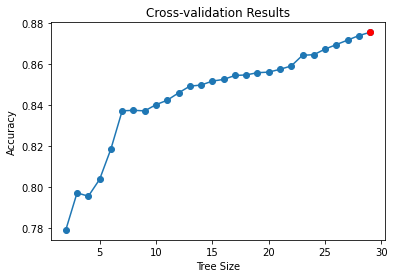

In [41]:
# fit decision tree model
tree_phishing = DecisionTreeClassifier(random_state=7)
tree_phishing.fit(X_train, y_train)

# cross-validation to determine optimal tree size
params = {'max_leaf_nodes': range(2, 30)}  
cv_phishing = GridSearchCV(tree_phishing, params, cv=10)
cv_phishing.fit(X_train, y_train)
cv_results = cv_phishing.cv_results_

# find the best score for max leaf nodes
best_size = cv_phishing.best_params_['max_leaf_nodes']
best_score = cv_phishing.best_score_

# plot results of cross-validation
plt.figure(figsize=(6, 4))
plt.plot(cv_results["param_max_leaf_nodes"], cv_results["mean_test_score"], 'o-')
plt.plot(best_size, best_score, 'ro-')
plt.xlabel('Tree Size')
plt.ylabel('Accuracy')
plt.title('Cross-validation Results');

### 2.3 Pruning the Tree

Choosing max leaf nodes as 7, because that was the last large gain in the cross validation results and still small enough number of nodes to intrepret the results.

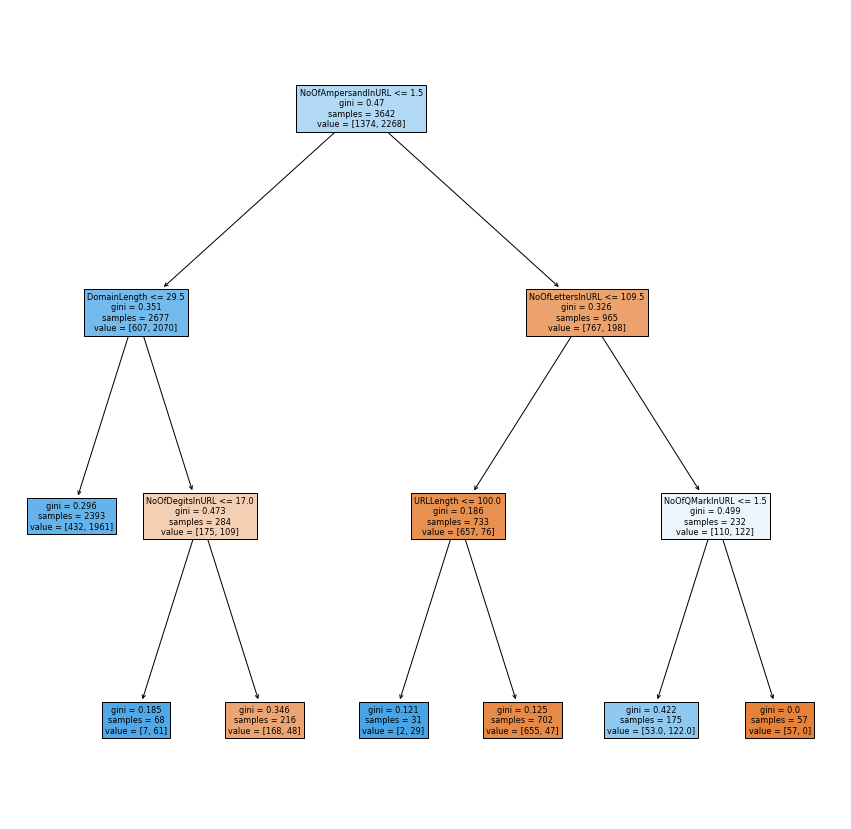

In [42]:
# prune tree using optimal size
prune_phishing = DecisionTreeClassifier(max_leaf_nodes=7, random_state=13)
prune_phishing.fit(X_train, y_train)

# plot pruned tree
plt.figure(figsize=(15,15))
plt.title('Pruned Tree')
plot_tree(prune_phishing, feature_names=X_train.columns, filled=True);

In [43]:
prune_summary = export_text(prune_phishing, feature_names=X_train.columns.tolist())
print(prune_summary)

|--- NoOfAmpersandInURL <= 1.50
|   |--- DomainLength <= 29.50
|   |   |--- class: 1
|   |--- DomainLength >  29.50
|   |   |--- NoOfDegitsInURL <= 17.00
|   |   |   |--- class: 1
|   |   |--- NoOfDegitsInURL >  17.00
|   |   |   |--- class: 0
|--- NoOfAmpersandInURL >  1.50
|   |--- NoOfLettersInURL <= 109.50
|   |   |--- URLLength <= 100.00
|   |   |   |--- class: 1
|   |   |--- URLLength >  100.00
|   |   |   |--- class: 0
|   |--- NoOfLettersInURL >  109.50
|   |   |--- NoOfQMarkInURL <= 1.50
|   |   |   |--- class: 1
|   |   |--- NoOfQMarkInURL >  1.50
|   |   |   |--- class: 0



In [44]:
# obtain predicted labels for test set
y_pred = prune_phishing.predict(X_test)

# create confusion matrix
confusion_matrix = pd.crosstab(index=y_pred, columns=y_test, rownames=[''])
print(confusion_matrix)

label    0    1
               
0      393   46
1      219  904


In [45]:
(393+904)/(393+46+219+904)

0.8303457106274008

### 3.1 Random Forests

In [46]:
# Add is https true variable
new_urls = pd.get_dummies(new_urls, columns=['IsHTTPs'], drop_first=True)

In [47]:
new_sample = new_urls[['URLLength', 'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL','DomainLength','IsHTTPs_True', 'label']]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(new_sample.drop('label',axis = 1)
                                                    , new_sample['label']
                                                    , test_size=0.3, random_state=13)

In [48]:
y_test.unique()

array([1, 0], dtype=int64)

In [49]:
# Scale the dataset
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 3.2 Tuning Parameters

In [50]:
param_grid = {
    'max_features': [1,2,3,5,7,9],
    'n_estimators': [200,400,600,800,1000]
}

rf = RFC(random_state=0)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')


# Fit GridSearchCV to the data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated score: {best_score}")

Best parameters: {'max_features': 1, 'n_estimators': 800}
Best cross-validated score: 0.9151536049684198


In [59]:
# Train the model with the best parameters
best_rf = grid_search.best_estimator_

# Predict on the test set
y_hat_bag = best_rf.predict(X_test_scaled)

# Calculate the mean squared error
accuracy = np.mean(y_hat_bag == y_test)
print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.9052496798975672


### 3.3 Variable Importance

In [60]:
# Feature Importance
feature_imp = pd.DataFrame(
    {'importance':best_rf.feature_importances_},
    index=['URLLength', 'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL','DomainLength','IsHTTPs_True'])
feature_imp.sort_values(by='importance', ascending=False)

,importance
URLLength,0.179561
DomainLength,0.165935
NoOfLettersInURL,0.161780
NoOfDegitsInURL,0.145390
NoOfEqualsInURL,0.095231
NoOfOtherSpecialCharsInURL,0.091227
NoOfAmpersandInURL,0.071683
NoOfQMarkInURL,0.062616
IsHTTPs_True,0.026576


### 3.4 Random Forest Results

In [65]:
from sklearn.metrics import confusion_matrix

mat_mgb = confusion_matrix(y_test, y_hat_bag)
mat_mgb

array([[499, 113],
       [ 35, 915]], dtype=int64)

In [80]:
(499+915)/(499+113+35+915)

0.9052496798975672

Text(0.5, 15.0, 'Predicted Values')

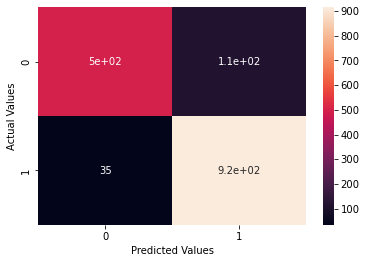

In [66]:
sns.heatmap(mat_mgb, annot=True)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

Text(0.5, 15.0, 'Predicted Values')

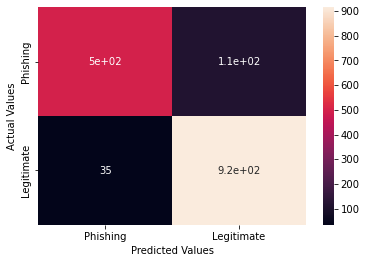

In [67]:
sns.heatmap(mat_mgb, annot=True,xticklabels=["Phishing","Legitimate"], yticklabels=["Phishing","Legitimate"])
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

### 4.1 Boosting

In [68]:
xgb_model = xgb.XGBClassifier()

params = {
    "colsample_bytree": uniform(0.5, 0.5),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.01, 0.2),
    "max_depth": randint(3, 10),
    "n_estimators": randint(100, 1000),
    "subsample": uniform(0.5, 0.5)
}

search = RandomizedSearchCV(xgb_model,
                            param_distributions=params,
                            n_iter=200,
                            cv=5,
                            verbose=1,
                            n_jobs=1,
                            return_train_score=True)

search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E425CDA280>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E425CEE8E0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E425C3EF10>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E425CEE5E0>},
                   return_train_score=True, verbose=1)

In [69]:
search.best_params_

{'colsample_bytree': 0.7995102524447197,
 'gamma': 0.28002471494419223,
 'learning_rate': 0.10015922473523929,
 'max_depth': 9,
 'n_estimators': 717,
 'subsample': 0.9133866573254272}

In [70]:
xgb_model = xgb.XGBClassifier()
xgb_model.set_params(**search.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7995102524447197, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.28002471494419223,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10015922473523929,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=717, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [71]:
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7995102524447197, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.28002471494419223,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10015922473523929,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=717, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### 4.2 Variable Importance

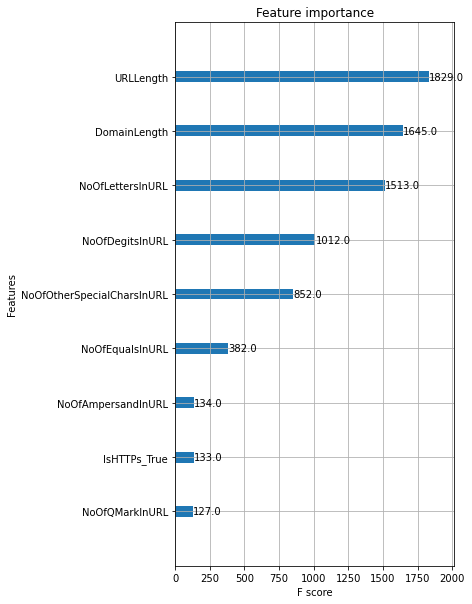

In [72]:
feature_names = ['URLLength', 'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL','DomainLength','IsHTTPs_True']
# Create a mapping of feature indices to actual feature names
feature_importance_dict = {i: feature_names[i] for i in range(len(feature_names))}

# Plot feature importance
fig, ax = plt.subplots(figsize=(5, 10))
xgb.plot_importance(xgb_model, ax=ax)
ax.set_yticklabels([feature_importance_dict[int(i.get_text().strip('f'))] for i in ax.get_yticklabels()])
plt.show()

### 4.3 Boosting Results

In [73]:
y_test.value_counts()

1    950
0    612
Name: label, dtype: int64

In [74]:
pred_mgb = xgb_model.predict(X_test_scaled)

In [75]:
mat_mgb = confusion_matrix(y_test, pred_mgb)
mat_mgb

array([[506, 106],
       [ 42, 908]], dtype=int64)

In [81]:
(506+908)/(506+106+42+908)

0.9052496798975672

Text(0.5, 15.0, 'Predicted Values')

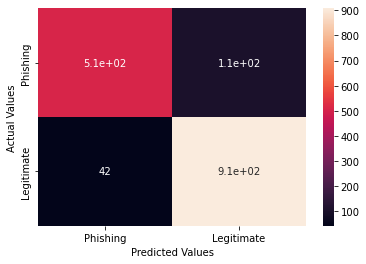

In [76]:
sns.heatmap(mat_mgb, annot=True,xticklabels=["Phishing","Legitimate"], yticklabels=["Phishing","Legitimate"])
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

In [77]:
print(classification_report(y_test, pred_mgb))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       612
           1       0.90      0.96      0.92       950

    accuracy                           0.91      1562
   macro avg       0.91      0.89      0.90      1562
weighted avg       0.91      0.91      0.90      1562



### 5.1 SVM

In [78]:
# train svm
from sklearn.svm import SVC

# grid search with SVC
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X_train_scaled, y_train)

print(grid.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.852 total time=   0.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.844 total time=   0.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.852 total time=   0.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.848 total time=   0.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.845 total time=   0.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.822 total time=   0.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.823 total time=   0.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.826 total time=   0.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.824 total time=   0.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

### 5.2 SVM Results

In [79]:
svm_pred = grid.best_estimator_.predict(X_test_scaled)

# create confusion matrix
confusion_matrix = pd.crosstab(index=svm_pred, columns=y_test, rownames=[''])
print(confusion_matrix)
print(classification_report(y_test, svm_pred))

label    0    1
               
0      491   46
1      121  904
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       612
           1       0.88      0.95      0.92       950

    accuracy                           0.89      1562
   macro avg       0.90      0.88      0.89      1562
weighted avg       0.89      0.89      0.89      1562

